In [266]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [225]:
start_date = '2015-01-01'
end_date = '2024-12-31'

df_init = yf.download(tickers='^BVSP', start=start_date, end=end_date, auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [229]:
df = df_init.copy()

df.columns = df.columns.droplevel(1)

df = df.resample('W-MON').sum()

df['return'] = df['Adj Close'].pct_change(1)
df['target'] = df['return'].shift(-1)
df.dropna(inplace=True)
df['target_bin'] = np.where(df['target'] >= 0, 1, 0)

In [230]:
def moving_calculation(df=None, period=4, columns='Adj Close', metric:str='avg'):
    if metric == 'avg':
        calculation = df[columns].rolling(window=period).mean()
    elif metric == 'std':
        calculation = df[columns].rolling(window=period).std()
    elif metric == 'sum':
        calculation = df[columns].rolling(window=period).sum()
    return calculation

def rsl_calculation(df=None, period=4, columns='Adj Close'):
    return df[columns]/df[columns].rolling(window=period).mean() - 1

def rsi_calculation(df=None, period=4, columns='return', n_bin=True):

    upper_time = (df[columns] >= 0).rolling(window=period).mean()
    down_time = (df[columns] < 0).rolling(window=4).mean()
    rs = upper_time/down_time
    rsi_metric = 100 - 100/(1 + rs)

    if n_bin:
        rsi = np.where(rsi_metric >= 70, 3,
                        np.where(rsi_metric <= 30, 1, 2)
        )
    else:
        rsi = rsi_metric

    return rsi


In [234]:
df['RSL_4'] = rsl_calculation(df, period=4)

df['MA_close_4'] = moving_calculation(df, period=4, metric='avg')

df['STD_close_4'] = moving_calculation(df, period=4, metric='std')

df['MA_return_2'] = moving_calculation(df, period=2, columns='return', metric='avg')
df['MA_return_4'] = moving_calculation(df, period=4, columns='return', metric='avg')

df['STD_return_2'] = moving_calculation(df, period=2, columns='return', metric='std')
df['STD_return_4'] = moving_calculation(df, period=2, columns='return', metric='std')

df['upper_band'] = df['MA_close_4'] + df['STD_close_4']
df['lower_band'] = df['MA_close_4'] - df['STD_close_4']

df['dist_band'] = (df['Adj Close'] - df['lower_band'])/(df['upper_band'] - df['lower_band'])

df['RSI_4'] =  rsi_calculation(df, period=4, columns='return', n_bin=True)
                        

df.dropna(inplace=True)

df.describe()

Price,Adj Close,Close,High,Low,Open,Volume,return,target,target_bin,RSL_4,MA_close_4,STD_close_4,MA_return_2,MA_return_4,STD_return_2,STD_return_4,upper_band,lower_band,dist_band,RSI_4
count,517.000000,517.000000,517.000000,517.000000,517.000000,5.170000e+02,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,439758.270793,439758.270793,443563.280464,435788.187621,439626.885880,3.469400e+07,0.012856,0.012112,0.531915,0.002992,438661.153772,37343.696846,0.012905,0.013662,0.125602,0.125602,476004.850618,401317.456926,0.518545,2.065764
std,136860.705636,136860.705636,137559.667536,136235.255224,136928.646999,1.930012e+07,0.152753,0.153857,0.499464,0.095482,131004.943478,26740.405164,0.087635,0.048085,0.124484,0.124484,138310.391766,128937.676796,0.466823,0.804257
min,129145.000000,129145.000000,131053.000000,128865.000000,130703.000000,5.454900e+06,-0.409480,-0.409480,0.000000,-0.349157,165076.750000,2249.968444,-0.229014,-0.120761,0.000077,0.000077,186208.145067,122893.312251,-0.249948,1.000000
25%,322133.000000,322133.000000,324304.000000,318124.000000,320802.000000,1.746460e+07,-0.022990,-0.023251,0.000000,-0.027991,322827.500000,11482.836308,-0.018757,-0.008618,0.013154,0.013154,339825.906980,289960.269970,0.061904,1.000000
50%,459762.000000,459762.000000,466099.000000,455346.000000,459818.000000,2.857640e+07,0.002373,0.002373,1.000000,0.021075,470884.500000,35411.363377,0.007000,0.011061,0.129185,0.129185,511263.760329,411211.926657,0.702917,2.000000
75%,555647.000000,555647.000000,560870.000000,549393.000000,555021.000000,5.044840e+07,0.027202,0.027202,1.000000,0.059115,543480.000000,56760.569797,0.039127,0.036361,0.184034,0.184034,590715.318908,500340.935248,0.894430,3.000000
max,681146.000000,681146.000000,684195.000000,677675.000000,683058.000000,1.009198e+08,0.715213,0.715213,1.000000,0.302975,677667.000000,147116.221659,0.357791,0.380365,0.792134,0.792134,714873.300427,673920.761798,1.248676,3.000000


In [241]:
df_model = df[['target_bin', 'RSL_4',  'RSI_4', 'MA_return_2', 'MA_return_4', 'STD_return_2', 'STD_return_4', 'dist_band']].copy()

df_model['RSL_4'] = pd.qcut(df['RSL_4'], q=5, labels=False)
df_model['MA_return_2'] = pd.qcut(df['MA_return_2'], q=5, labels=False)
df_model['MA_return_4'] = pd.qcut(df['MA_return_4'], q=5, labels=False)
df_model['STD_return_2'] = pd.qcut(df['STD_return_2'], q=5, labels=False)
df_model['STD_return_4'] = pd.qcut(df['STD_return_4'], q=5, labels=False)
df_model['dist_band'] = pd.qcut(df['dist_band'], q=5, labels=False)

In [259]:
y = df_model['target_bin']
X = df_model.iloc[:,1:]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

Acurácia:  0.6374269005847953


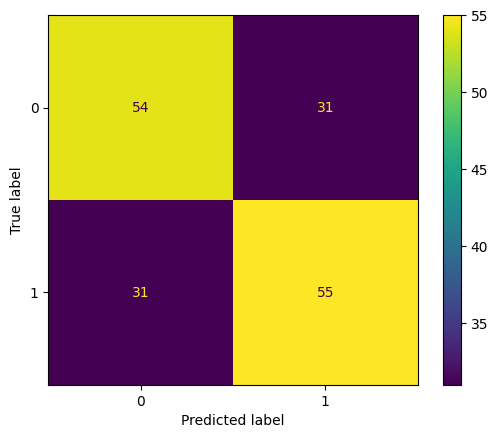

In [267]:
model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print('Acurácia: ', accuracy_score(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [303]:
df_evaluate = y_test.to_frame()\
    .merge(df['target'], left_index=True, right_index=True, how='inner')\

df_evaluate['target_predict'] = y_pred


df_evaluate['result'] = np.where(df_evaluate['target_bin'] == df_evaluate['target_predict'], np.abs(df_evaluate['target']), -np.abs(df_evaluate['target'])) * 1000

df_evaluate_series = df_evaluate.resample('M')['result'].sum().cumsum()

C:\Users\lucas\AppData\Local\Temp\ipykernel_14728\1884453971.py:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



<Axes: xlabel='Date'>

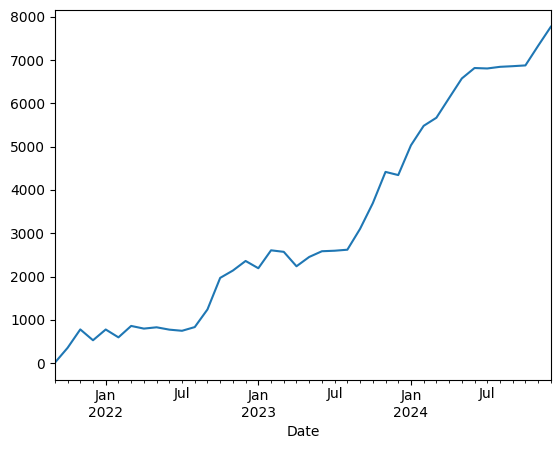

In [304]:
df_evaluate_series.plot(y='result')

In [291]:
df_evaluate.describe().T

,count,mean,std,min,25%,50%,75%,max
target_bin,171.0,0.502924,0.501460,0.000000,0.000000,1.000000,1.000000,1.000000
target,171.0,0.006297,0.135687,-0.406704,-0.020513,0.000114,0.020874,0.645154
target_predict,171.0,0.502924,0.501460,0.000000,0.000000,1.000000,1.000000,1.000000
result,171.0,0.045423,0.127967,-0.311556,-0.008296,0.005125,0.054737,0.645154


Acurácia:  0.6374269005847953


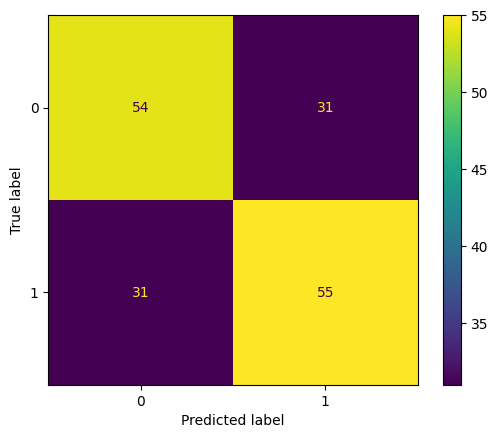

In [293]:
print('Acurácia: ', accuracy_score(df_evaluate['target_bin'], df_evaluate['target_predict']))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()